In [163]:
#Import

#Modelling
from mesa import Agent, Model

#Analysis
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.time import RandomActivation

In [164]:
from typing import Any

#testing if git works

#Model

class MoneyModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={
            "Gini coefficient": compute_gini #function defined below
        },
        agent_reporters={
            "Agent wealth": "wealth",
            "Agent position": "pos",
        }, #agent attributes
    )
        
    # Create agents
        for unique_id in range(self.num_agents):
            agent = MoneyAgent(unique_id, self)
            self.schedule.add(agent)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

#Agent

class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        # run the __init__ method of the parent class
        super().__init__(unique_id, model)
        # additional initialization for the derived class
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,  # current position
            moore=True,  # including step on the diagonal
            include_center=False,  # to remain at current position is not allowed
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

#Gini coefficient

def compute_gini(model):
    N = model.num_agents

    # collect wealth of agent into a list and sort it in increasing order
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)

    # calculate the Gini coefficient
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / sum(x)
    G = (N + 1 - 2 * B) / N

    return G

In [165]:
#We run the model with 50 agents distributed in a 10x10 grid of cells for 100 time steps.

model = MoneyModel(50, 10, 10)

for i in range(100):
    model.step()

In [166]:
#Collecting stored data

model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

model_df.head(5)

,Gini coefficient
0,0.0000
1,0.2456
2,0.3512
3,0.4088
4,0.5128


In [167]:
agent_df.tail(4)

Agent wealth Agent position
Step AgentID                             
99   46                  8         (6, 3)
     47                  0         (5, 4)
     48                  0         (1, 4)
     49                  0         (0, 1)

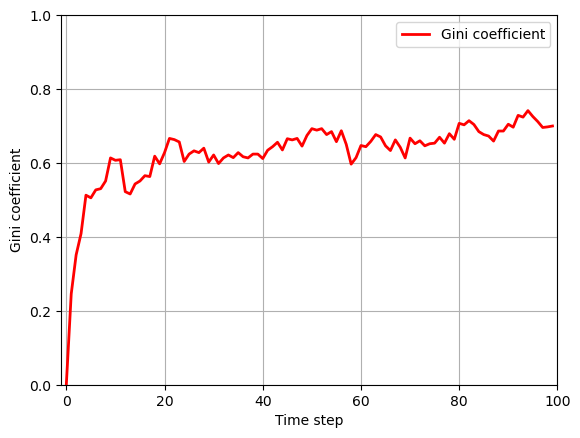

In [168]:
import matplotlib.pyplot as plt

model_df.plot(color="r", lw=2)

plt.ylabel("Gini coefficient")
plt.xlabel("Time step")
plt.grid("on")
plt.setp(plt.gca(), xlim=(-1, 100), ylim=(0, 1))

plt.show()

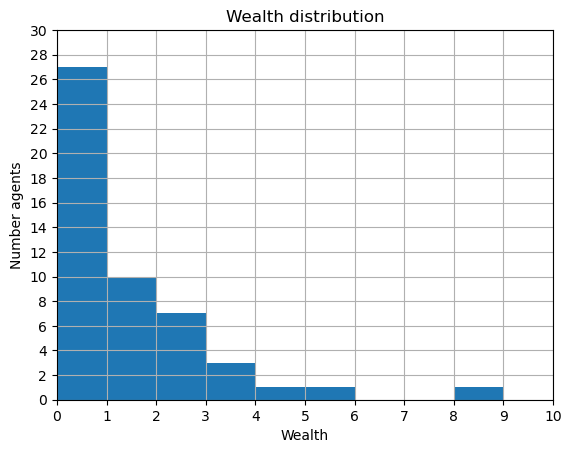

In [169]:
# extract a cross section of the dataframe for the final time step
final_wealth_df = agent_df.xs(99, level="Step")

# plot a histogram
final_wealth_df.hist(bins=range(11))

plt.title("Wealth distribution")
plt.ylabel("Number agents")
plt.xlabel("Wealth")
plt.setp(
    plt.gca(), xlim=(0, 10), xticks=range(11), ylim=(0, 30), yticks=range(0, 31, 2)
)

plt.show()

In [170]:
step_idx, agent_idx = agent_df.idxmax().iloc[0]

print("Agent:", agent_idx)
print("Step:", step_idx)

Agent: 46
Step: 98


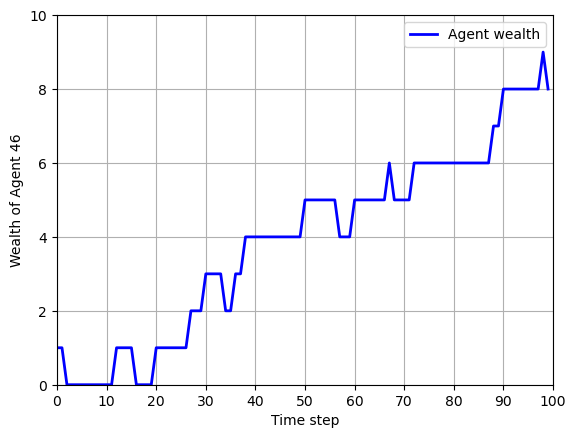

In [171]:
one_agent_wealth_df = agent_df.xs(agent_idx, level="AgentID")

one_agent_wealth_df.plot(lw=2, color="b")

plt.ylabel(f"Wealth of Agent {agent_idx}")
plt.xlabel("Time step")

plt.grid(True)
plt.setp(
    plt.gca(),
    xlim=(0, 100),
    xticks=range(0, 101, 10),
    ylim=(0, 10),
    yticks=range(0, 11, 2),
)

plt.show()